In [58]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import plotly.express as px
import numpy as np
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from mlxtend.feature_selection import SequentialFeatureSelector
from sklearn.neighbors import LocalOutlierFactor
from sklearn.model_selection import GridSearchCV #probar
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, Normalizer
from imblearn.over_sampling import SMOTE
from sklearn.pipeline import Pipeline, TransformerMixin
from sklearn.model_selection import cross_validate

from sklearn.metrics import plot_roc_curve, auc
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC, NuSVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold

import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.wrappers.scikit_learn import KerasClassifier

In [34]:
data_dir = 'data'

In [73]:
def over_sampling(X: np.array, y: np.array) -> tuple:
  sm = SMOTE(random_state = 42)
  return sm.fit_resample(X, y)

def outlier(X: np.array) -> list:
  clf    = LocalOutlierFactor(n_neighbors=20)
  yhat   = clf.fit_predict(X)
  mask   = yhat != -1
  return mask

def pca(X: np.array, n_components: int = 2) -> np.array:
  pca = PCA(n_components = n_components)
  pca.fit(X)
  return pca.transform(X)

def lda(X: np.array, y: np.array, n_components: int = 1) -> np.array:
  clf = LinearDiscriminantAnalysis(n_components = n_components)
  clf.fit(X, y)
  return clf.transform(X)

def selectKBest(X: np.array, y: np.array, k = 2):
  return SelectKBest(chi2, k=k).fit_transform(X, y)

def sequentialFeatureSelector(X: np.array, y: np.array, k = 3):
  knn = KNeighborsClassifier(n_neighbors = 3)
  sfs = SequentialFeatureSelector(knn, k_features = k)
  sfs.fit(X, y)
  return sfs.transform(X)

def get_name_clf(clf):
    return clf.__class__.__name__

def neuronal_network(n_features: int):
    clf = Sequential()
    clf.add(Dense(32, activation='relu', input_dim = n_features))
    clf.add(Dense(64, activation='relu'))
    clf.add(Dense(1, activation='sigmoid'))
    clf.compile(loss='binary_crossentropy', optimizer='adam', metrics=["accuracy"])
    return clf

def print_measure(model: dict):
  #print(model.name,"\n\tscore_train: %.3f | score_test: %.3f" % (model.auc_measure_train, model.auc_measure_test)
  return "%s\n\tscore_train: %.3f | score_test: %.3f" %(model["name"],model["AUC_train"], model["AUC_test"])

In [36]:
classifiers = [
  LogisticRegression(),
  GaussianNB(),
  KNeighborsClassifier(11),
  SVC(kernel="rbf", C=0.025, probability=True),
  NuSVC(probability=True),
  DecisionTreeClassifier(),
  RandomForestClassifier(),
  AdaBoostClassifier(),
  GradientBoostingClassifier(),
  #KerasClassifier(neuronal_network, n_features=3, epochs=100, batch_size=32, verbose=0)
]

CLASSIFIERS = [(get_name_clf(clf), clf) for clf in classifiers]

print(CLASSIFIERS[2])

NORMALIZATION = [
  ('StandardScaler', StandardScaler()),
  ('Normalizer', Normalizer())
]

FEATURE_EXTRACTION = [
  ('SFS k = 2', SequentialFeatureSelector(KNeighborsClassifier(n_neighbors = 2), k_features = 2)),
  ('SFS k = 3', SequentialFeatureSelector(KNeighborsClassifier(n_neighbors = 3), k_features = 3))
]

('KNeighborsClassifier', KNeighborsClassifier(n_neighbors=11))


## Data Exploration

In [37]:
data = pd.read_csv('%s/heart_failure_clinical_records_dataset.csv' %(data_dir))
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 299 entries, 0 to 298
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   age                       299 non-null    float64
 1   anaemia                   299 non-null    int64  
 2   creatinine_phosphokinase  299 non-null    int64  
 3   diabetes                  299 non-null    int64  
 4   ejection_fraction         299 non-null    int64  
 5   high_blood_pressure       299 non-null    int64  
 6   platelets                 299 non-null    float64
 7   serum_creatinine          299 non-null    float64
 8   serum_sodium              299 non-null    int64  
 9   sex                       299 non-null    int64  
 10  smoking                   299 non-null    int64  
 11  time                      299 non-null    int64  
 12  DEATH_EVENT               299 non-null    int64  
dtypes: float64(3), int64(10)
memory usage: 30.5 KB


<AxesSubplot:xlabel='DEATH_EVENT', ylabel='count'>

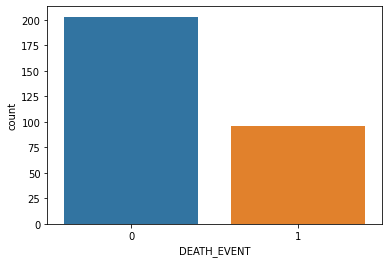

In [38]:
sns.countplot(x = 'DEATH_EVENT', data = data)

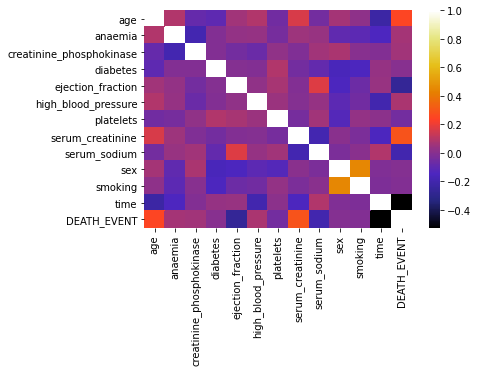

In [39]:
sns.heatmap(data.corr(), cmap="CMRmap")
plt.show() #sacar conclusiones

In [40]:
X_embedded = TSNE(n_components=2).fit_transform(data)

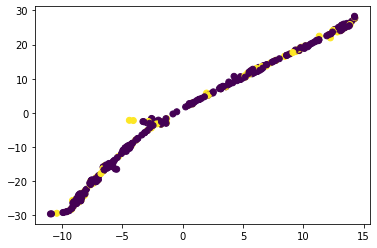

In [41]:
plt.scatter(X_embedded[:,0], X_embedded[:,1], c=data.DEATH_EVENT)
plt.show() #sacar conlusiones

Pocos outliers 

Distrubución complicada para clasificadores simples

### Data Preparation

In [42]:
class dataset:

  def __init__(self, X: np.array, y: np.array, name: str = ""):
    self.X = X
    self.y = y
    self.name = name

  def split(self, test_size: int = 15) -> tuple:

    if  not 0 < test_size < 100: raise RuntimeError("Wrong percentage range")

    return train_test_split(self.X, self.y, test_size = test_size/100)

In [43]:
ds_base = dataset(data.values[:, :-1], data.values[:, -1], name = "basic")

mask: list = outlier(ds_base.X)
ds_without_outlier = dataset(ds_base.X[mask, :], ds_base.y[mask], name = "without outlier")

x_aux,y_aux = over_sampling(ds_without_outlier.X, ds_without_outlier.y)
ds_SMOTE = dataset(x_aux, y_aux, name = "SMOTE aumentation")

DATASETS = [
    ds_base,
    ds_without_outlier,
    ds_SMOTE
]

## Modeling

In [53]:
class Model:

  def __init__(self, pipeline: Pipeline):
    self._pipeline = pipeline
    
    self.estimators        = []
    self.name              = " + ".join(pipeline.named_steps.keys())
    self.auc_measure_train = 0
    self.auc_measure_test  = 0

  def train(self, X_train: np.array, y_train: np.array, cv: int = 5) -> float:
    result = cross_validate(
        pipe, 
        X_train, 
        y_train, 
        cv = cv,
        scoring=('roc_auc'),
        return_estimator = True
      )
    
    self.estimators        = result['estimator']
    self.auc_measure_train = np.mean(result['test_score'])

    return self.auc_measure_train                                       

  def evaluate(self, X_test: np.array,  y_test: np.array) -> float:

    for estimator in self.estimators:
      yhat = estimator.predict_proba(X_test)[:,1]
      fpr, tpr, _ = roc_curve(y_test, yhat)
      self.auc_measure_test += auc(fpr, tpr)
    
    self.auc_measure_test /= len(self.estimators)
    return self.auc_measure_test

  def getMeasure(self) -> dict:
    return {
        "AUC_test": self.auc_measure_test,
        "AUC_train": self.auc_measure_train,
        "name": self.name,
        "estimators": self.estimators
    }

In [67]:
class ModelsCollection:

  def __init__(self):
    self.collection = []

  def add(self, item):
     self.collection.append(item)

  def size(self) -> int:
    return len(self.collection)

  def get(self, index: int) -> Model:
    return self.collection[index]

  def chooseTheBest(self, number: int = 3):
    self.collection.sort(
      key = lambda x: x["AUC_test"],
      reverse = True
    )
    return self.collection[0:number]


In [46]:
class ModelsBuilder:

  def build(self):
    for clf in CLASSIFIERS:
      yield Pipeline(steps=[
                            ('StandardScaler', StandardScaler()),
                            clf
                            ])



In [75]:
builder = ModelsBuilder()
l = {}
for ds in DATASETS:
  l[ds.name] = ModelsCollection()
  X_train, X_test, y_train, y_test = ds.split()
  print("\n")
  print("#"*10, ds.name.upper(), "DATASET ", "#"*10, "\n")
  index = 0
  for pipe in builder.build():
    model = Model(pipe)
    model.train(X_train, y_train)
    model.evaluate(X_test, y_test)
    l[ds.name].add(model.getMeasure())
    print(model)
    index += 1
  print("#############################")
  for m in l[ds.name].chooseTheBest():
    print(m)
    
    #curve_data[get_name_clf(classifier)] = models
  



########## BASIC DATASET  ########## 

StandardScaler + LogisticRegression
	score_train: 0.869 | score_test: 0.827
StandardScaler + GaussianNB
	score_train: 0.833 | score_test: 0.827
StandardScaler + KNeighborsClassifier
	score_train: 0.798 | score_test: 0.719
StandardScaler + SVC
	score_train: 0.850 | score_test: 0.833
StandardScaler + NuSVC
	score_train: 0.838 | score_test: 0.830
StandardScaler + DecisionTreeClassifier
	score_train: 0.740 | score_test: 0.770
StandardScaler + RandomForestClassifier
	score_train: 0.899 | score_test: 0.888
StandardScaler + AdaBoostClassifier
	score_train: 0.844 | score_test: 0.813
StandardScaler + GradientBoostingClassifier
	score_train: 0.890 | score_test: 0.866
#############################
{'AUC_test': 0.8877777777777778, 'AUC_train': 0.8992693400889766, 'name': 'StandardScaler + RandomForestClassifier', 'estimators': (Pipeline(steps=[('StandardScaler', StandardScaler()),
                ('RandomForestClassifier', RandomForestClassifier())]), Pipel

## Comparative

In [62]:
def build_comparatie_plots(index: int, curve_data: list, title: str) -> None:
  plt.figure(index)
  tprs = []
  aucs = []
  mean_fpr = np.linspace(0, 1, 100)

  fig, ax = plt.subplots()
  for i,model in enumerate(curve_data):
      viz = plot_roc_curve(model, X_test, y_test,
                          name='ROC fold {}'.format(i),
                          alpha=0.3, lw=1, ax=ax)
      interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
      interp_tpr[0] = 0.0
      tprs.append(interp_tpr)
      aucs.append(viz.roc_auc)

ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
          label='Chance', alpha=.8)

  mean_tpr = np.mean(tprs, axis=0)
  mean_tpr[-1] = 1.0
  mean_auc = auc(mean_fpr, mean_tpr)
  std_auc = np.std(aucs)
  ax.plot(mean_fpr, mean_tpr, color='b',
          label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
          lw=2, alpha=.8)

  std_tpr = np.std(tprs, axis=0)
  tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
  tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
  ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                  label=r'$\pm$ 1 std. dev.')

  ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
        title=title)
  ax.legend(loc="lower right")
  plt.show()

<Figure size 432x288 with 0 Axes>

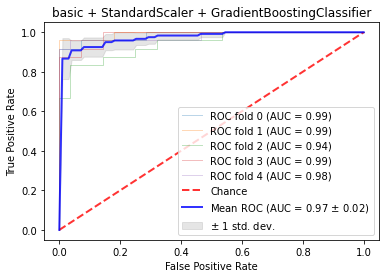

<Figure size 432x288 with 0 Axes>

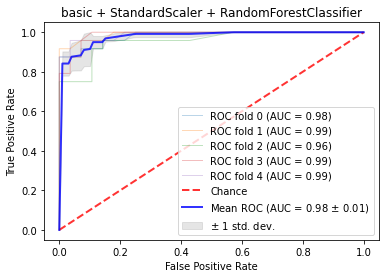

<Figure size 432x288 with 0 Axes>

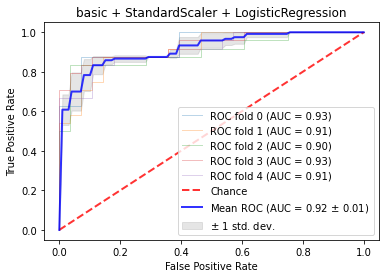

<Figure size 432x288 with 0 Axes>

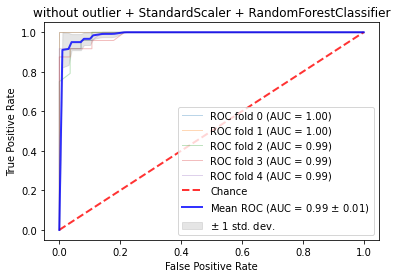

<Figure size 432x288 with 0 Axes>

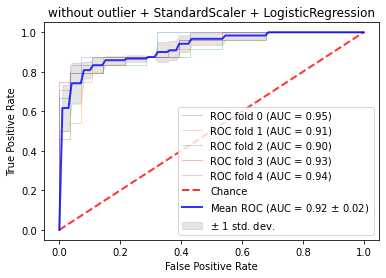

<Figure size 432x288 with 0 Axes>

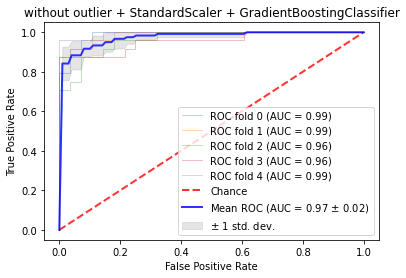

<Figure size 432x288 with 0 Axes>

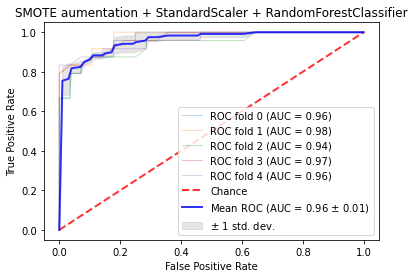

<Figure size 432x288 with 0 Axes>

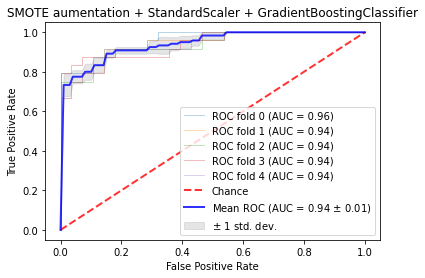

<Figure size 432x288 with 0 Axes>

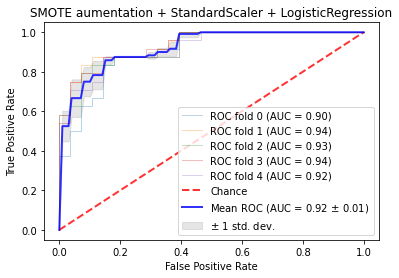

In [69]:
for ds in DATASETS:
    for index, est in enumerate(l[ds.name].chooseTheBest()):
        build_comparatie_plots(index, est['estimators'], "%s + %s" % (ds.name, est['name']))
